## Problem Definition

#PROBLEM DEFIINITION CONTEXT

In [1]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path
import os
import math

from sandbox_src.utils.config import load_config
from sandbox_src.preprocessing.preprocessing import DataPreprocess
from sandbox_src.feature_engineering.feature_engineering import ClusterFeatureEngine
from sandbox_src.model_development.model_development import ModelDevelopment

import warningswarnings.filterwarnings('ignore')
from darts.models import (
    AutoARIMA,
    LightGBMModel,
    RegressionModel,
    LinearRegressionModel
)
import random
#import lightgbm as lgbm
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics.metrics import mae, mse
#from sktime.forecasting.compose import make_reduction, TransformedTargetForecaster
#from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#from sktime.forecasting.compose import TransformedTargetForecaster
#from sktime.transformations.series.detrend import Detrender
#from sktime.forecasting.trend import PolynomialTrendForecaster
#from sktime.transformations.series.detrend import Deseasonalizer

[2022-03-29 11:14:56,128] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).
Importing plotly failed. Interactive plots will not work.


## Importing Data

In [2]:
df_disks = pd.read_csv("sandbox_synthetic_train_data.csv", parse_dates=["Date"])
df_disks.set_index(["Date"], inplace=True)


In [3]:
df_disks

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,26.000000,32.000000,23.000000,11.000000,18.000000,27.000000,13.000000,23.000000,30.000000,29.000000,...,32.000000,42.000000,40.000000,31.000000,20.000000,40.000000,40.000000,30.000000,39.000000,45.000000
2022-01-02,25.164229,32.934208,23.767508,11.413182,18.114692,27.635833,12.620166,22.151559,30.924577,28.686095,...,31.863012,42.299517,40.978051,31.883150,20.916240,39.011968,39.411968,31.050904,37.260928,44.621817
2022-01-03,24.301035,33.159261,24.542706,10.544558,18.989186,26.954619,12.831877,22.314634,30.473023,29.398625,...,32.186121,42.658744,40.110016,31.024494,20.630688,39.695189,40.495189,31.293997,38.608082,45.873891
2022-01-04,24.786593,33.391173,25.155790,11.357127,19.584818,26.241311,12.633970,23.286229,30.598197,28.652404,...,33.176839,42.188093,40.967830,30.798523,19.915371,40.893997,42.093997,30.688369,38.454251,44.179465
2022-01-05,25.353681,33.165377,26.023170,11.415367,19.799340,27.224058,12.925220,22.354024,30.833053,29.478356,...,33.213634,42.013921,40.610700,30.842225,20.573071,40.580611,42.180611,29.998847,37.733062,46.180240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-27,37.821327,47.794968,41.017484,27.315690,38.604849,44.953726,21.121150,34.750594,41.220697,45.170174,...,53.933839,57.836318,51.265542,42.385818,39.234100,39.173290,73.173290,46.006148,46.302127,49.338128
2022-03-28,38.337808,48.117277,41.449784,26.864187,38.111417,45.694889,21.643697,35.145528,41.782418,44.427013,...,54.215371,58.505128,51.991692,42.887705,38.948211,39.316584,73.716584,46.772117,47.299294,49.646876
2022-03-29,37.448022,48.800963,42.158853,27.510666,38.579122,45.202227,21.584654,35.890268,41.576622,44.406256,...,54.846071,59.000098,52.828161,43.715065,38.393170,40.615874,75.415874,47.944299,45.724357,48.634934


In [5]:
#Please specify the number of disks for this demo
#Choose between 10 to 30 and press Enter
nb_of_disks = int(input())

#Filter columns based on the given input
df_disks = df_disks.iloc[:, :nb_of_disks]

2


In [6]:
df_disks

,0,1
Date,,
2022-01-01,26.000000,32.000000
2022-01-02,25.164229,32.934208
2022-01-03,24.301035,33.159261
2022-01-04,24.786593,33.391173
2022-01-05,25.353681,33.165377
...,...,...
2022-03-27,37.821327,47.794968
2022-03-28,38.337808,48.117277
2022-03-29,37.448022,48.800963


In [7]:
df_disks.describe()

,0,1
count,90.000000,90.000000
mean,32.258671,40.506934
std,3.739942,4.319320
min,24.301035,32.000000
25%,30.545156,36.807033
50%,32.469513,41.245721
75%,35.191337,43.570651
max,39.268006,48.895881


## Initialize Class Instances

In [8]:
# Load config
config = load_config('config.yml')

In [9]:
# Create necessary class instances
preprocessor = DataPreprocess()
feature_engine = ClusterFeatureEngine(config=config)
model_development = ModelDevelopment(config=config)

## Clustering

#Raysiz haliyle sadece 2 disk için deniyelim...

In [10]:
df_disks_w_2disks = df_disks.iloc[:, :2]
df_disks_w_2disks

,0,1
Date,,
2022-01-01,26.000000,32.000000
2022-01-02,25.164229,32.934208
2022-01-03,24.301035,33.159261
2022-01-04,24.786593,33.391173
2022-01-05,25.353681,33.165377
...,...,...
2022-03-27,37.821327,47.794968
2022-03-28,38.337808,48.117277
2022-03-29,37.448022,48.800963


In [11]:
%%time

errors_df = feature_engine.cluster_disks(df_disks_w_2disks)

CPU times: user 25min 17s, sys: 1min 20s, total: 26min 38s
Wall time: 1min 56s


In [12]:
errors_df

,diskname,lgbm_7_model_mae_mean,lgbm_7_model_mae_std,lgbm_30_model_mae_mean,lgbm_30_model_mae_std,arima_30_model_mae_mean,arima_30_model_mae_std
0,0,1.838813,0.975323,2.640144,0.636033,2.798495,0.823476
1,1,2.373196,0.539590,2.422386,0.144601,1.266411,0.493651


## Model Selection Based on Clustering

#diskleri eşleştiriyoruz...

In [13]:
model_mapping_df = feature_engine.get_model_selection(errors_df)

/data/scanalytics/KS_DiskKapasiteTahminleme/sandbox_src/feature_engineering/feature_engineering_demo.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_df["is_same"]=df_means_stds["equal"]
/data/scanalytics/KS_DiskKapasiteTahminleme/sandbox_src/feature_engineering/feature_engineering_demo.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  std_df["is_same"]=df_means_stds["equal"]
/data/scanalytics/KS_DiskKapasiteTahminleme/sandbox_src/feature_engineering/feature_engineering_demo.py:178: SettingWit

In [14]:
model_mapping_df

,CurrentAvgMae,CurrentStdMae,ModelId,DiskName
0,2.64014,0.63603,3,0
1,2.42239,0.14460,3,1


## Making Predictions

#prediction üretiyoruz...

In [15]:
#Get last 30 days from main df for our input data
training_df = df_disks.iloc[-30:, :2]

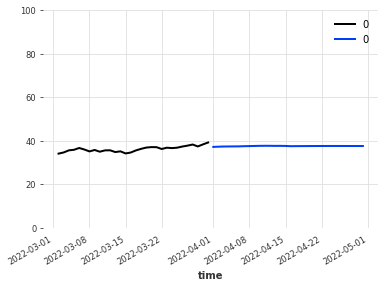

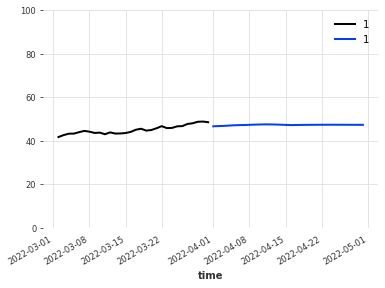

CPU times: user 37.1 s, sys: 1.92 s, total: 39 s
Wall time: 3.03 s


In [16]:
%%time

predictions_df = pd.DataFrame()

#Make predictions by iterating on each column from main df
for i in training_df.columns:
    
    series = training_df.loc[:, i]
    diskname = int(i)
    model_id = model_mapping_df[model_mapping_df["DiskName"].astype("int64") == diskname]["ModelId"].iloc[0]

    if model_id == 1:
        series = preprocessor.convert_series2darts(series)
        prediction = model_development.predict_arima(series)
    elif model_id == 2:
        series = preprocessor.convert_series2darts(series.iloc[-14:])
        prediction = model_development.predict_lgbm_14(series)
    elif model_id == 3:
        series = preprocessor.convert_series2darts(series)
        prediction = model_development.predict_lgbm_30(series)
    elif model_id == 4:
        prophet_df = preprocessor.convert_series2prophetdf(series.iloc[-7:])
        prediction = model_development.predict_prophet(prophet_df)
    else:
        prophet_df = preprocessor.convert_series2prophetdf(series)
        prediction = model_development.predict_prophet(prophet_df)
        
    predictions_df[i] = prediction.pd_dataframe()


    series.plot()
    prediction.plot()
    plt.ylim(0,100)
    plt.show()
    

In [17]:
predictions_df

,0,1
time,,
2022-04-01,37.239739,46.712905
2022-04-02,37.347061,46.817490
2022-04-03,37.413803,46.898635
2022-04-04,37.445935,47.042936
2022-04-05,37.466048,47.178000
2022-04-06,37.489343,47.268325
2022-04-07,37.569720,47.300561
2022-04-08,37.615759,47.394700
2022-04-09,37.677619,47.489427


## Evaluation

#evaluation bilgisi

In [18]:
#Import test data
test_df = pd.read_csv("sandbox_synthetic_test_data.csv", parse_dates = ["Date"])
test_df.set_index("Date", inplace = True)

In [19]:
# Filter first 2 disks as we did in training set
test_df = test_df.iloc[:, :2]

In [20]:
test_df

,0,1
Date,,
2022-04-01,40.209190,47.971589
2022-04-02,40.120165,48.199495
2022-04-03,40.560819,49.174359
2022-04-04,40.721151,49.251212
2022-04-05,41.647724,49.887557
2022-04-06,42.577860,49.605232
2022-04-07,43.148463,50.043724
2022-04-08,42.943008,50.239132
2022-04-09,43.156843,49.601710


In [21]:
#Evaluate results using Mean Absolute Error

for i in test_df.columns:
    
    print("Error on disk {}: {}".format(i, mean_absolute_error(test_df[i], training_df[i])))

Error on disk 0: 6.302865281532773
Error on disk 1: 6.7400061160115365


# Solving the Problem with Ray

#ray hakkında bilgi...

In [22]:
import ray

In [23]:
ray.shutdown()
ray.init(log_to_driver=False, include_dashboard=False)

{'node_ip_address': '172.18.228.122',
 'raylet_ip_address': '172.18.228.122',
 'redis_address': '172.18.228.122:6379',
 'object_store_address': '/tmp/ray/session_2022-03-29_11-17-08_882261_2368174/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-29_11-17-08_882261_2368174/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-29_11-17-08_882261_2368174',
 'metrics_export_port': 56427,
 'gcs_address': '172.18.228.122:41243',
 'node_id': '8b08d7223b824b05b3415c4c62ee3be1252a58fe7ae878e3318b98fc'}

In [24]:
@ray.remote 
def main_flow(disk_series):
    NUMBER_OF_DIFFERENT_LAGS = 2
    diskname = disk_series.name

    if len(disk_series) > 0:

        disk_series = disk_series.round(decimals=5)
        disk_series = disk_series.iloc[-75:] 

        # Iterate over day lags (last 7 or 30days)
        for j in range(NUMBER_OF_DIFFERENT_LAGS):

            # If the length of the number of training days = 7
            if j == 0:
                # Create sliding windows for train and test
                length = len(disk_series)
                window_size = 15

                lgbm_7_mae_list = []

                for k in range(window_size, length - 30):
                    train = TimeSeries.from_series(disk_series.iloc[k - window_size:k-1])
                    test = TimeSeries.from_series(disk_series.iloc[k:k + 30])

                    ####MODEL TRAINING####
                    # Initalize Autoregressive LightGBM Model with 7 days lag
                    lgbm_model = LightGBMModel(lags=[-7, -6, -5, -4, -3, -2, -1])
                    # Train the model
                    lgbm_model.fit(series=train)
                    # Predict disk storage for the upcoming 30 days
                    prediction_lgbm = lgbm_model.predict(n=1)
                    # Create prediction timeseries
                    prediction_lgbm_7 = prediction_lgbm
                    # Shift time series with the prediction
                    train1 = train.append(prediction_lgbm)[1:]

                    # Repeat process for 30 days prediction
                    for c in range(29):
                        lgbm_model = LightGBMModel(lags=[-7, -6, -5, -4, -3, -2, -1])
                        lgbm_model.fit(series=train1)
                        prediction_lgbm = lgbm_model.predict(n=1)
                        # Append new predictions to timeseries
                        prediction_lgbm_7 = prediction_lgbm_7.append(prediction_lgbm)
                        train1 = train1.append(prediction_lgbm)[1:]

                    # Evaluate model using MAE for the sliding windows
                    lgbm_mae = mae(actual_series=test, pred_series=prediction_lgbm_7[1:])
                    # print('MAE: %f' % lgbm_mae)
                    lgbm_7_mae_list.append(lgbm_mae)


                lgbm_7_model_mae_mean = np.mean(lgbm_7_mae_list)
                lgbm_7_model_mae_std = np.std(lgbm_7_mae_list)

            # If length of training days = 30
            elif j == 1:


                # Create sliding windows for train and test
                length = len(disk_series)
                window_size = 31

                lgbm_30_mae_list = []
                autoarima_30_mae_list = []

                for k in range(window_size, length - 30):
                    train = TimeSeries.from_series(disk_series.iloc[k - window_size:k - 1])
                    test = TimeSeries.from_series(disk_series.iloc[k:k + 30])

                    ####MODEL TRAINING####
                    # Autoregressive LightGBM Model
                    # Initalize Autoregressive LightGBM Model with 15 days lag
                    lgbm_model = LightGBMModel(lags=[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1])
                    # Train the model
                    lgbm_model.fit(series=train)
                    # Predict disk storage for the upcoming 30 days
                    prediction_lgbm = lgbm_model.predict(n=1)
                    # Create prediction timeseries
                    prediction_lgbm_30 = prediction_lgbm
                    # Shift time series with the prediction
                    train1 = train.append(prediction_lgbm)[1:]

                    # Repeat process for 30 days prediction
                    for c in range(29):
                        lgbm_model = LightGBMModel(lags=[-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1])
                        lgbm_model.fit(series=train1)
                        prediction_lgbm = lgbm_model.predict(n=1)
                        # Append new predictions to timeseries
                        prediction_lgbm_30 = prediction_lgbm_30.append(prediction_lgbm)
                        train1 = train1.append(prediction_lgbm)[1:]

                    # Evaluate model using MAE for the sliding windows
                    lgbm_mae = mae(actual_series=test, pred_series=prediction_lgbm_30[1:])
                    # print('MAE: %f' % lgbm_mae)
                    lgbm_30_mae_list.append(lgbm_mae)

                    # Auto-ARIMA Model
                    autoarima_model = AutoARIMA(start_p=1, start_q=1, max_p=7, max_q=7)
                    autoarima_model.fit(series=train)
                    prediction_autoarima_30 = autoarima_model.predict(n=30)
                    # Evaluate model using MAE for the sliding windows
                    autoarima_30_mae = mae(actual_series=test, pred_series=prediction_autoarima_30[1:])
                    # print('MAE: %f' % disk_mae)
                    autoarima_30_mae_list.append(autoarima_30_mae)

                lgbm_30_model_mae_mean = np.mean(lgbm_30_mae_list)
                lgbm_30_model_mae_std = np.std(lgbm_30_mae_list)
                arima_30_model_mae_mean = np.mean(autoarima_30_mae_list)
                arima_30_model_mae_std = np.std(autoarima_30_mae_list)

    errors_df = feature_engine.create_model_error_df(diskname, lgbm_7_model_mae_mean, lgbm_7_model_mae_std, lgbm_30_model_mae_mean, lgbm_30_model_mae_std, arima_30_model_mae_mean, arima_30_model_mae_std)
    model_mapping_result = feature_engine.get_model_selection(errors_df)
    
    return model_mapping_result

In [25]:
%%time

futures = []
for col in df_disks.columns:
    futures.append(main_flow.remote(df_disks[col]))
ray.get(futures)

CPU times: user 1.42 s, sys: 273 ms, total: 1.7 s
Wall time: 47.2 s


[   CurrentAvgMae  CurrentStdMae  ModelId  DiskName
 0        2.64014        0.63603        3         0,
    CurrentAvgMae  CurrentStdMae  ModelId  DiskName
 0        2.42239         0.1446        3         1]

Raysiz haliyle 2 disk = 3dk 28sn = 104sn/disk

Rayli haliyle 15 disk = 2dk 9s = 8.6sn/disk



In [ ]:
#TODO: prediction with ray